In [2]:
library(bbmle)
library(tidyverse)
library(deSolve)
dev.new(width=8, height=3.5)

Loading required package: stats4
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::slice()  masks bbmle::slice()


## Objectives
1. Decide on model for data, justify why this model has been chosen. Looking like SEIR at the moment.
2. Generate an incidence curve from the model.
3. Start using same fitting techniques as on Flu prevalence but fit on our incidence curve since the dataset is incidence.

Consider other models with inverse hessian to find uncertainties. Fit $E_0$ and $I_0$ with predetermined parameters. Look at correlation plot of parameters, try fitting on $R_0$. Linearise, to a quadratic ODE find dominant eigenvalue. Implement MCMC.

## Dataset
Using the dataset obtained from Kelley Islands Influenza outbreak in 1920. 

S   E   I   R 
688   1   0   0

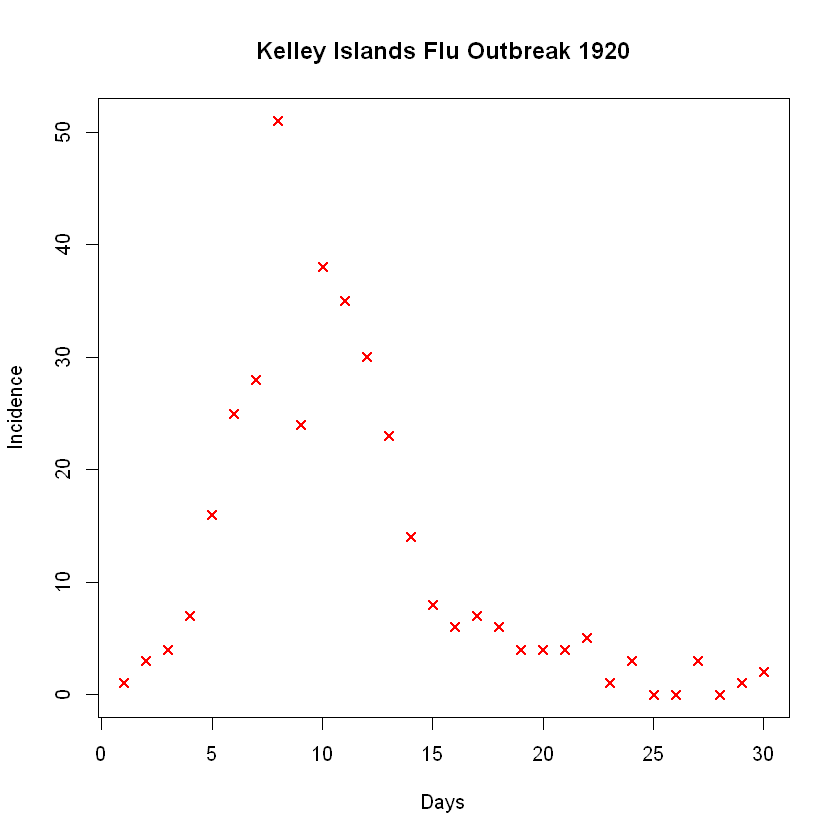

In [11]:
df <- select(data.frame(read.csv('kelley_islands.csv')), c('days', 'cases'))
plot(df$days, df$cases, xlab='Days', ylab='Incidence', col='red', pch=4, lwd=1.6)
title('Kelley Islands Flu Outbreak 1920')
N <- 689

initial_data <- c(S=N-1, E=1, I=0, R=0)
initial_data

## Model: SEIR
First choice of model is an SEIR model, where susceptibles become exposed to the disease for a period of time before becoming infectious. So our model is: 

$\frac{dS}{dt} = -\frac{\beta{S}{I}}{N}$

$\frac{dE}{dt} = \frac{\beta{S}{I}}{N} - \alpha{E}$

$\frac{dI}{dt} = \alpha {E} - \gamma{I}$

$\frac{dZ}{dt} = \gamma{I}$

We have 3 parameters in this model; $\gamma, \beta, \alpha$. Some consideration as to what our data represents in our model is also needed. 
Our data is incidence of _infectious_ members, whereas our model gives the prevalence of the infectious members ($I(t)$).
We can make the incidence curve though, for time $d$ where the report interval is $1$ (as it is in our dataset). Given instantaneous incidence $C(t) = \frac{\beta S(t) I(t)}{N} $:

$C_d = \int^{d+1}_{d} C(t) dt = \int^{d+1}_{d} \beta S(t)I(t) dt$

Now say our model is calculated at $n$ points between $d+1$ and $d$, so $t_i = d+ih$ for $h=\frac{1}{n}$. Then we can apply the composite trapezium rule: 
$C_d = h[\frac{1}{2}(C(d)+C(d+1)) + \sum_{j=1}^{n-1}{C(x_j)}]$

In [4]:
model <- function(parameters, initial_conditions, time){
    equations <- function(time, variables, parameters) {
        with(as.list(c(variables, parameters)), {
            N <- S+E+I+R
            dS <- -beta * I * S/N
            dE <- beta * S*I/N - alpha * E
            dI <- alpha*E - gamma*I
            dR <-  gamma * I
            return(list(c(dS, dE, dI, dR)))
        })
    }
    out <- ode(
        y = initial_conditions,
        times = c(0,time),
        func = equations,
        parms = parameters
    )
    return(as.data.frame(out)[-1,])
}
incidence <- function(params, from, to, n=100){
    time_points <- seq(from, to, 1/n)
    model_data <- model(params, initial_conditions=initial_data, time=time_points)
    model_data$C <- params['beta']*model_data$S*model_data$I/N
    ends <- tail(model_data$C, n=1) + model_data$C[1] 
    total <- sum(model_data$C) - 0.5*ends
    return(1/n*total)
}
incidence_curve <- function(params, times){
    inc_data <- data.frame(time=times[1], incidence=incidence(params, times[1], times[2]))
    for(i in 3:length(times)){
        instant <- incidence(params, times[i-1], times[i])
        inc_data[nrow(inc_data) + 1,] = c(times[i-1], instant)
    }
    return(inc_data)
}

We now have an incidence curve, so we can fit our data.

In [5]:
time_length <- 30
incidence_times <- seq(0, time_length, 0.1)

In [6]:
ss <- function(params){
    predictions <- incidence_curve(params, times = df$days)
    sum((predictions$incidence - df$cases)^2)
}
starting_param_val <- c(beta=1.9, gamma=1.4, alpha=50)
ss_optim <- optim(starting_param_val, ss)

Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"lo

"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter objec

"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter objec

"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter object length"Warning message in predictions$incidence - df$cases:
"longer object length is not a multiple of shorter objec

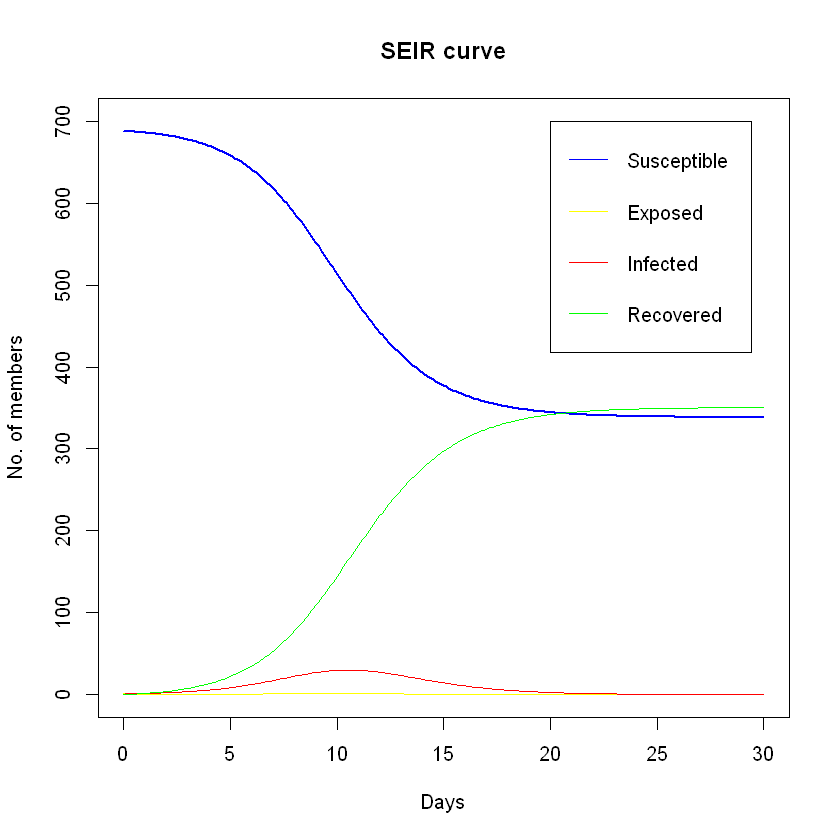

In [7]:
params<- ss_optim$par
times <- seq(0,time_length, 0.1)
data <- model(params, initial_data, times)
plot(loess(data$S~times),type='l', col='blue',  xlab='Days', ylab='No. of members', pch=4, lwd=1.6, ylim=c(0,700))

legend(20, 700, legend=c("Susceptible", "Exposed", "Infected", "Recovered"), col=c("blue", "yellow", "red","green"),
       lty=1, y.intersp=2)
lines(loess(data$E~times), type='l',col='yellow')
lines(loess(data$I~times),type='l', col='red' )
lines(loess(data$R~times),type='l', col='green')

title('SEIR curve')

## Analysis
When do we know that an SEIR model is not appropiate? 

In [8]:
params

beta     gamma     alpha 
 1.748794  1.254084 28.967396

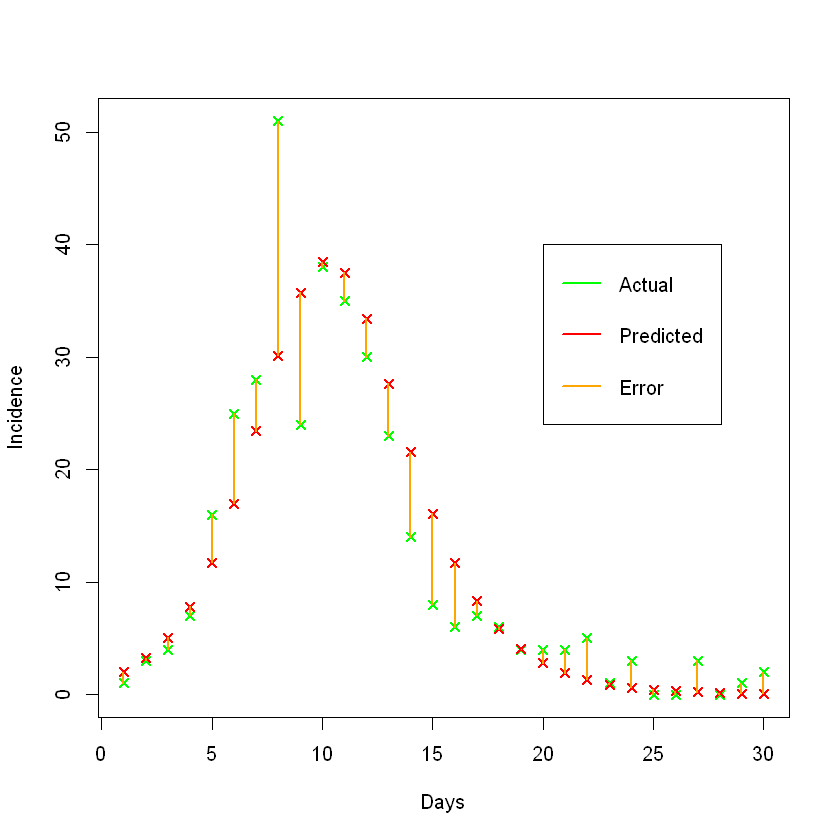

In [9]:
inc_data <- incidence_curve(params=params, times=seq(0,30))
plot(df$days, df$cases, xlab='Days', ylab='Incidence', col='green', pch=4, lwd=1.6)
points(df$days, inc_data$incidence, col='red', pch=4, lwd=1.6)
legend(20, 40, legend=c("Actual", "Predicted", "Error"), col=c("green", "red", "orange"), lty=1:1,lwd=1.6, y.intersp=2)
arrows(df$days, df$cases,df$days, inc_data$incidence, length=0.1, angle=90, code=0, col='orange', lwd=1.7)